In [49]:
##Import
from scipy.stats import binom
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [220]:
##Defs
def bc_transformation(bc_nt, bc_CFU):
    #bc_nt is the number of random nucleotides used to create barcodes
    #bc_CFU is the number of transformants during the cloning of the barcode library
    max_bcs = 4 ** bc_nt #NOTE: this will cause problems with bc_nt over 15
    n = bc_CFU
    p = float(1)/max_bcs   
    used_bcs = max_bcs * (1-binom.pmf(0,n,p))
    return used_bcs

def bc_transformation_distro(bc_nt, bc_CFU):
    #bc_nt is the number of random nucleotides used to create barcodes
    #bc_CFU is the number of transformants during the cloning of the barcode library
    max_bcs = 4 ** bc_nt #NOTE: this will cause problems with bc_nt over 15
    n = bc_CFU
    p = float(1)/max_bcs   
    used_bcs = max_bcs * (1-binom.pmf(0,n,p))
    bc_distro = {}
    for i in range(0,51):
        bc_distro[i] = max_bcs * binom.pmf(i,n,p)
    return bc_distro

def var_to_bc(bc_pool, variants, var_CFU):
    p = float(1)/bc_pool
    single_bc_prop = binom.pmf(1,var_CFU,p)
    multi_bc_prop = float(1) - binom.pmf(1,var_CFU,p) - binom.pmf(0,var_CFU,p)
    multi_bcs = multi_bc_prop * var_CFU
    multi_bcs_OK = 0 #barcodes that were chosen more than once, but still only associated with one variant
    multi_bcs_prop = 0
    for i in range(2,500):
        multi_bcs_OK += binom.pmf(i,var_CFU,p) * binom.pmf(i,multi_bcs,float(1)/variants) * var_CFU
        multi_bcs_prop += binom.pmf(i,var_CFU,p) * binom.pmf(i,multi_bcs,float(1)/variants)
    useful_prop = (single_bc_prop+multi_bcs_prop)/(single_bc_prop+multi_bc_prop)    #proportion of eventual reads with a useful barcode (associated with only one variant)
    per_variant_trials = var_CFU/variants
    variants_with_useful_bc_prop = 1 - binom.pmf(0,per_variant_trials,single_bc_prop+multi_bcs_prop)
    useful_bcs_per_variant = variants_with_useful_bc_prop * per_variant_trials
#     bc_prop = {}
#     for i in range(0,2000):
#         bc_prop[i] = binom.pmf(i,var_CFU,p)
    return variants_with_useful_bc_prop, useful_prop, useful_bcs_per_variant



## 1. Create the barcoded plasmid library (optimize for number of nucleotides in barcode, barcode cloning CFU)

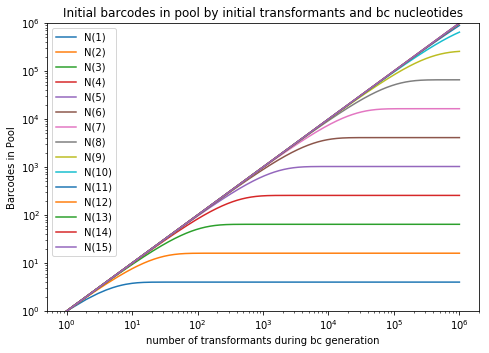

In [3]:
##Number of unique barcodes generated in first cloning step (Ns in primer to pre-barcode vector)
x = np.arange(1,1000000,1)
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
for i in range(1,16):
    ax.plot(x,bc_transformation(i,x),label='N(%s)' % i)
ax.set_title("Initial barcodes in pool by initial transformants and bc nucleotides")
ax.set_xlabel('number of transformants during bc generation')
ax.set_ylabel('Barcodes in Pool')
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim([1,1000000])
plt.legend()
plt.show()

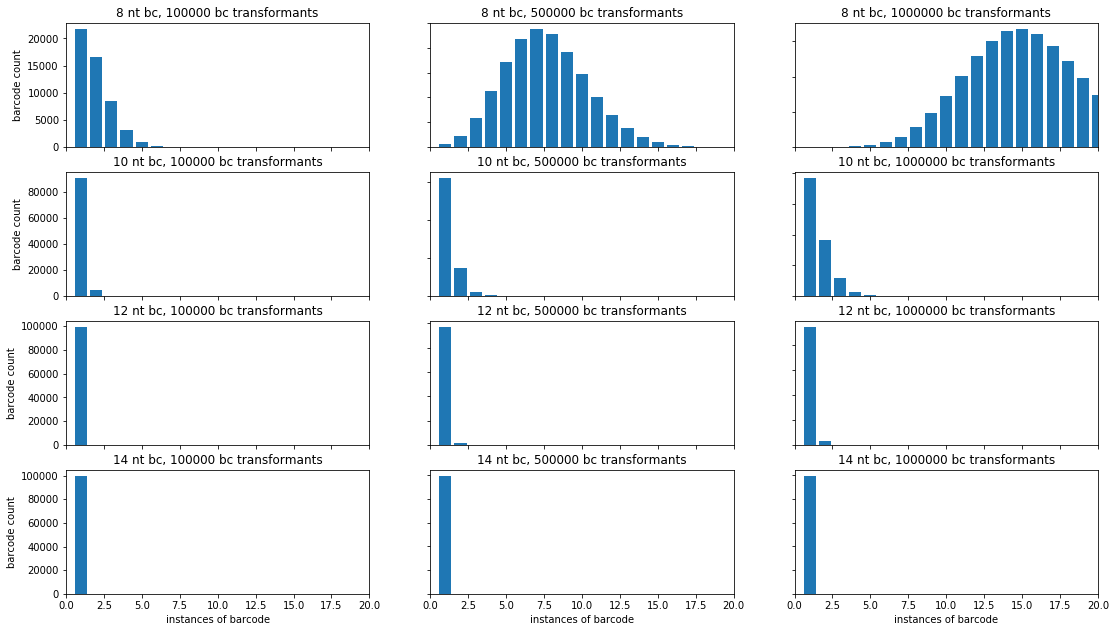

In [4]:
##### Distribution of barcode count in cloned library (how non-uniform are the barcodes)
fig, axs = plt.subplots(4,3, sharex=True)
nts = [8,10,12,14]
transformants = [100000,500000,1000000]
for nt in enumerate(nts):
    for trans in enumerate(transformants):
        x = []
        y = []
        cond_dict = bc_transformation_distro(nt[1],trans[1])
        for i in range(1,50):
            x.append(i)
            y.append(cond_dict[i])
        axs[nt[0],trans[0]].bar(x,y)
        axs[nt[0],trans[0]].set_title('%s nt bc, %s bc transformants' %(nt[1],trans[1]))
       
        
for ax in axs.flat:
    ax.set(xlabel='instances of barcode', ylabel='barcode count')

plt.xlim(0,20)
fig.set_size_inches(18.5, 10.5)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Take Away: use >10 Ns for barcodes, you will be practically limited by the number of transformants rather than the number of possible barcodes. Additional barcode nucleotides will prevent over-representing individual barcodes so that you can more reasonably make the assumption that you are cloning into a uniform barcode library in the next steps.

## 2. Clone variants into the barcode libraries (variables: barcode diversity going in, number of variants in pool, variant cloning CFU)

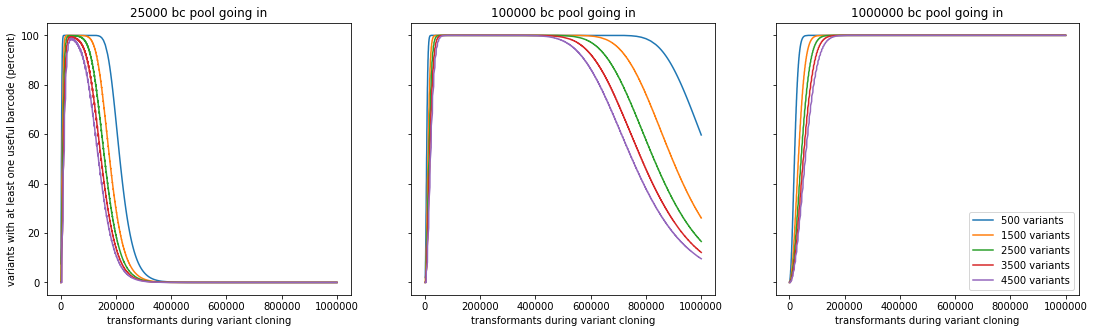

In [221]:
##Useful variants (vs CFU,barcodes,variants) -- variants with at least one barcode associated with them
fig, axs = plt.subplots(1,3, sharex=True)
bc_pools = [25000,100000,1000000]
for pool in enumerate(bc_pools):
    for var in range(500,5000,1000):
        x = np.arange(1000,1000000,100)
        axs[pool[0]].plot(x,(var_to_bc(pool[1],var,x)[0]*100),label="%s variants" %var)
        axs[pool[0]].set_title('%s bc pool going in' % pool[1])

for ax in axs.flat:
    ax.set(xlabel='transformants during variant cloning', ylabel='variants with at least one useful barcode (percent)')        

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# ax.set_xscale('log')
fig.set_size_inches(18.5, 5)
plt.legend()
plt.show()

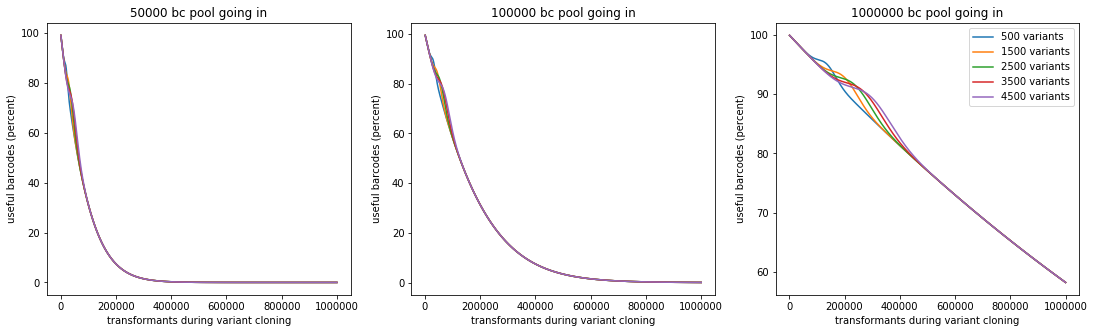

In [224]:
##Useful barcodes (vs CFU,barcodes,variants) -- how many sequencing reads will be useful (vs barcode reads that are ambiguous)
fig, axs = plt.subplots(1,3, sharex=True)
bc_pools = [50000,100000,1000000]
for pool in enumerate(bc_pools):
    for var in range(500,5000,1000):
        x = np.arange(1000,1000000,100)
        axs[pool[0]].plot(x,(var_to_bc(pool[1],var,x)[1]*100),label="%s variants" %var)
        axs[pool[0]].set_title('%s bc pool going in' % pool[1])

for ax in axs.flat:
    ax.set(xlabel='transformants during variant cloning', ylabel='useful barcodes (percent)')        

# ax.set_xscale('log')
fig.set_size_inches(18.5, 5)
plt.legend()
plt.show()

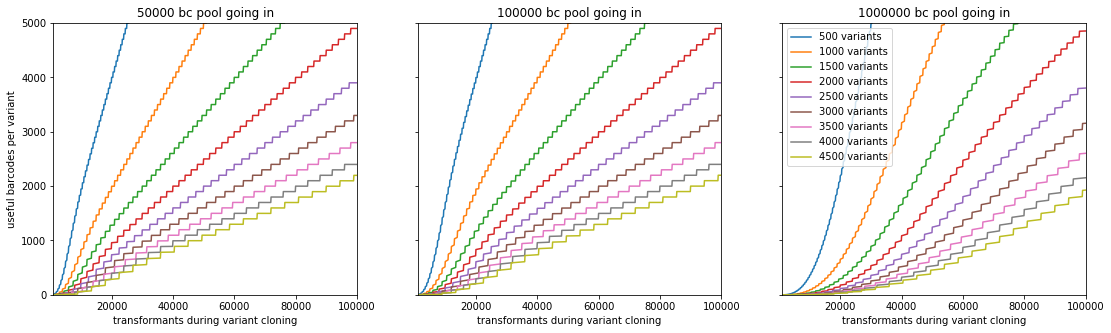

In [232]:
##Useful barcodes per variant (vs CFU,barcodes,variants)
fig, axs = plt.subplots(1,3, sharex=True, sharey=True)
bc_pools = [50000,100000,1000000]
for pool in enumerate(bc_pools):
    for var in range(500,5000,500):
        x = np.arange(1000,100000,100)
        axs[pool[0]].plot(x,(var_to_bc(pool[1],var,x)[2]*100),label="%s variants" %var)
        axs[pool[0]].set_title('%s bc pool going in' % pool[1])

for ax in axs.flat:
    ax.set(xlabel='transformants during variant cloning', ylabel='useful barcodes per variant')        

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

# ax.set_yscale('log')
# ax.set_xscale('log')
plt.xlim(1000,100000)
plt.ylim(1,5000)
fig.set_size_inches(18.5, 5)
plt.legend()
plt.show()

## 3. Bottleneck the library to reduce the number of barcodes associated with each variant (variables: variant library CFU, barcodes per variant)
### not completed

# Estimation playground to explore experimental values

In [252]:
bc_nt = 15
bc_CFU = 1000000
variants = 1000
var_CFU = 100000
bc_pool = bc_transformation(bc_nt, bc_CFU)
print ('%s barcodes in initial pool' % bc_pool)

cloned_pool = var_to_bc(bc_pool, variants, var_CFU)
print ('%s percent of variants with at least one useful bc' % (cloned_pool[0]*100))
print ('%s percent of barcodes are useful (only mark one variant)' % (cloned_pool[1]*100))
print ('%s barcodes per variant' % cloned_pool[2])

999534.483704567 barcodes in initial pool
99.99268333391186 percent of variants with at least one useful bc
95.40920568085497 percent of barcodes are useful (only mark one variant)
99.99268333391186 barcodes per variant
